### Experiment Design

In [1]:
import itertools
import os
from collections import namedtuple

import luigi
import dill
import numpy as np
from scipy.stats import binom

from experiment_framework.utils.helpers import AllAsymptotics
from notebook_context.pandas_interface import load_completed_AAs_into_dataframe, CCCS_for_AA, load_completed_CCCs_into_dataframe
from empirical_privacy import one_bit_sum, config

from notebook_context import *

### Run experiments

In [39]:
n = 1
p = 0.60
d = 3
ds = {
    'n_trials': n, 'prob_success': p, 'gen_distr_type': 'multidim_binom',
}
asys = {
    'gen_sample_kwargs'  : {'generate_in_batch': True,
                            'x_concatenator': 'numpy.vstack',
                           },
    'fitter'             : 'knn',
    # we use random tie-breaking since the samples are discrete
    'fitter_kwargs'      : {'neighbor_method': 'gyorfi'},
    'n_docs'                : 50,
    'confidence_interval_width': 0.05,
    'min_samples'        : 2**5,
    'n_max'              : 2**8,
    'validation_set_size': 2**10,
    'p'                  : 0.9,  # for bootstrap
    'n_bootstraps'       : 1000,  # for bootstrap,
    'in_memory'          : True
}
fit_model = asys['fitter_kwargs']['neighbor_method']

All = AllAsymptotics(
        gen_sample_path='empirical_privacy.one_bit_sum.GenSampleOneBitSum',
        dataset_settings=ds,
        asymptotic_settings=asys)


In [3]:
# # uncomment to delete outputs and dependencies to re-run the experiments
# for AA in All.requires():
#     AA.delete_outputs()
#     AA.delete_deps()
# for CCC in CCCs:
#     CCC.delete_outputs()
#     CCC.delete_deps()

In [ ]:
%%time
luigi.build([All],
#             local_scheduler=True,
            workers=2, log_level='ERROR')


In [4]:
AAs = All.requires()
CCCs = list(itertools.chain(*[CCCS_for_AA(AA) for AA in AAs]))
DF = load_completed_AAs_into_dataframe(AAs)
n_docs = DF.doc_ind.nunique()
DF = DF[DF.n_max==DF.n_max.max()]

In [5]:
DF

,confidence_interval_prob,confidence_interval_width,doc_ind,gen_distr_type,in_memory,knn_curve_model,lb_one_sided,lb_two_sided,lower_bound,min_samples,n_bootstraps,n_curves_done,n_max,n_trials,prob_success,ub_one_sided,ub_two_sided,upper_bound,validation_set_size
0,0.9,0.05,0,multidim_binom,True,gyorfi,0.637585,0.632943,0.632943,32,1000,41,256,1,0.6,0.672874,0.678489,0.678489,1024
1,0.9,0.05,1,multidim_binom,True,gyorfi,0.647123,0.642274,0.642274,32,1000,31,256,1,0.6,0.683352,0.688845,0.688845,1024
2,0.9,0.05,2,multidim_binom,True,gyorfi,0.633217,0.626340,0.626340,32,1000,41,256,1,0.6,0.668350,0.672504,0.672504,1024
3,0.9,0.05,3,multidim_binom,True,gyorfi,0.647347,0.641621,0.641621,32,1000,41,256,1,0.6,0.685013,0.690005,0.690005,1024
4,0.9,0.05,4,multidim_binom,True,gyorfi,0.605770,0.601057,0.601057,32,1000,41,256,1,0.6,0.642207,0.648929,0.648929,1024
5,0.9,0.05,5,multidim_binom,True,gyorfi,0.642281,0.636958,0.636958,32,1000,41,256,1,0.6,0.678162,0.682779,0.682779,1024
6,0.9,0.05,6,multidim_binom,True,gyorfi,0.638118,0.633167,0.633167,32,1000,41,256,1,0.6,0.671089,0.676212,0.676212,1024
7,0.9,0.05,7,multidim_binom,True,gyorfi,0.649156,0.643794,0.643794,32,1000,31,256,1,0.6,0.689384,0.693709,0.693709,1024
8,0.9,0.05,8,multidim_binom,True,gyorfi,0.640926,0.635315,0.635315,32,1000,41,256,1,0.6,0.675614,0.680970,0.680970,1024
9,0.9,0.05,9,multidim_binom,True,gyorfi,0.619647,0.613634,0.613634,32,1000,41,256,1,0.6,0.656349,0.662610,0.662610,1024


---

### Compute $P(Correct)$ based on stat dist

In [6]:
from scipy.special import comb
def multidim_binom_stat_dist(p, d):
    q = 1-p
    n_combos = 2**d
    stat_dist = 0
    for k in range(d+1):
        n_combos_with_k = comb(d, k)
        p_1 = n_combos_with_k * p**k * q**(d-k)
        p_2 = n_combos_with_k * q**k * p**(d-k)
        delta_prob = np.abs(p_1 - p_2)
        stat_dist += delta_prob
    return 0.5*stat_dist
        

pc = 0.5+0.5*multidim_binom_stat_dist(p, 3)
print(pc)

0.648


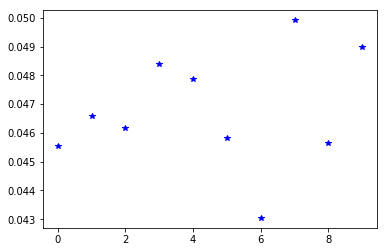

In [7]:
plt.plot(DF.ub_two_sided-DF.lb_two_sided, '*b')

In [8]:
DF.shape[0]

10

In [9]:
n_success = DF[(DF['lb_two_sided']<=pc) & (DF['ub_two_sided']>=pc)].shape[0]
n_total = DF.shape[0]

print(f"""Success probability {n_success/n_total:.2f} over {n_total} trials
with bootstrap confindence interval probability of {asys["p"]:.2f}.""")

Success probability 1.00 over 10 trials
with bootstrap confindence interval probability of 0.90.


### Plot outcomes for all trials

In [18]:
configure_plotting_for_publication()


import pandas as pd

from scipy.optimize import least_squares


from experiment_framework.asymptotic_analysis import asymptotic_privacy_lr, transform_n_to_k_for_knn, asymptotic_curve

from experiment_framework.privacy_estimator_mixins import get_k

SAVE_FIGURES_FOR_LATEX = True

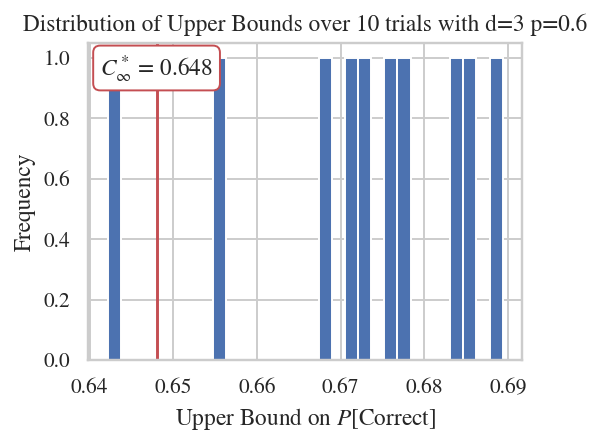

In [12]:
ax = DF.ub_one_sided.plot(kind='hist', bins=30)
true_ub = pc
plt.axvline(x=true_ub, color='r')
plt.text(x=true_ub,
         y=0.9,
         s='$C_\infty^*$ = {:.3f}'.format(true_ub),
         transform=x_data_y_axis(),
         horizontalalignment='center',
         bbox=dict(facecolor='w', edgecolor='r', boxstyle='round')
        )
plt.xlabel('Upper Bound on $P[$Correct$]$')
plt.title('Distribution of Upper Bounds over {ntri} trials with d={d} p={p}'.format(
    ntri=asys['n_docs'],
    d=d,
    p=p
))

if SAVE_FIGURES_FOR_LATEX:
    plt.title('')
    plt.ylabel('Frequency')
    plt.xlabel('Estimated Upper Bound on $C^*_\infty$')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH, 'experiment_1_upper_bound_histogram.eps'))

### Plot the details for a single trial

In [19]:
from notebook_context import *
from notebook_context.plots import plot_convergence_curve_dataframe
configure_plotting_for_publication()

In [20]:
DFccc = load_completed_CCCs_into_dataframe(CCCs)

Training set sizes =  32 -- 256
asymptote m=0.6506376787957016 curve C=0.13971938875835888


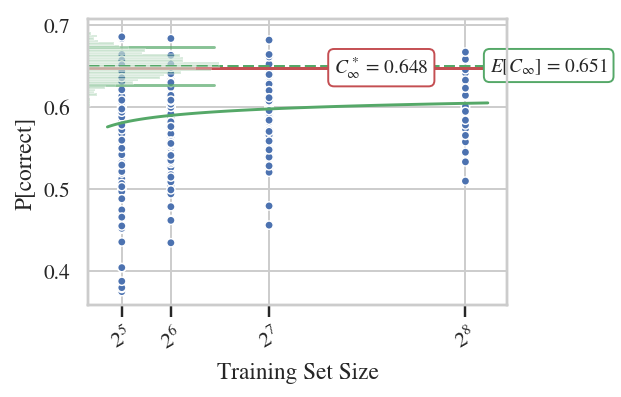

In [38]:
from experiment_framework.asymptotic_analysis import construct_bootstrap

def plot_convergence_curve_dataframe(DF, doc_ind=None, d=d, fit_model=fit_model,
                n_bootstrap_samples=1000, confidence_interval_prob=0.9):
    print('Training set sizes = ',
          DF.training_set_size.min(),
          '--',
          DF.training_set_size.max()
         )
    if doc_ind is not None:
        DF = DF.loc[DF.doc_ind == doc_ind, :]

    n_docs = DF.doc_ind.nunique()
    cp = sns.color_palette('hls', n_docs, desat=0.9)
    handle = sns.scatterplot(
        data=DF,
        x='training_set_size',
        y='classifier_accuracy',
        hue=None,
        legend=None,
        palette=cp,
        color='b',
        size=1
    )
     
   
    # curve for all the data
    x = DF.training_set_size.values.astype(np.double)
    y = DF.classifier_accuracy.values

    ks = transform_n_to_k_for_knn(x, fit_model=fit_model, d=d)
    m, C = asymptotic_curve(ks.reshape(ks.size), y.reshape(y.size))
    print(f'asymptote m={m} curve C={C}')
    
    # plot the sample distributions
#     plt.violinplot(
#         dataset=y,
#         widths=20,
#         positions=x,
#         showextrema=False
#     )
    handle = plt.gca()
    
    # bootstrap for ub
    tss = DF.training_set_size.unique()
    tss_to_accuracy = {ts: DF[DF.training_set_size==ts].classifier_accuracy.values for ts in tss}
    EB = construct_bootstrap(tss_to_accuracy, d=d, fit_model=fit_model)
    samples = EB.get_bootstrap_means(n_bootstrap_samples)

    ub = EB.bootstrap_confidence_bounds(confidence_interval_prob, n_bootstrap_samples).ub_two_sided
    lb = EB.bootstrap_confidence_bounds(confidence_interval_prob, n_bootstrap_samples).lb_two_sided
    base = config.SAMPLES_BASE
    xx = np.logspace(np.log(np.min(x))/np.log(base)*0.9,
                     np.log(np.max(x))/np.log(base)*1.01,
                    base=base)
    kks = transform_n_to_k_for_knn(xx, fit_model, d=d)
    plt.plot(xx, m+C*kks, '-g')
    
    plt.axhline(ub, xmax=0.3,color='g', linestyle='-', alpha=0.7)
    plt.axhline(lb, xmax=0.3, color='g', linestyle='-', alpha=0.7)
    plt.axhline(m, color='g', linestyle='--')
    plt.axhline(pc, color='r', linestyle='-')
    labeled_axhline(m, '$E[C_\infty]$', 'g', handle, linestyle='--', x_pos=1.1)
    labeled_axhline(pc, '$C_\infty^*$', 'r', handle, x_pos=0.7)
    
    xuniq = np.unique(x)
    plt.xticks(xuniq, ['$2^{%s}$'%'{:}'.format(int(np.log(xx)/np.log(2))) for xx in xuniq],
              rotation=30)
    
    if SAVE_FIGURES_FOR_LATEX:
        plt.xlabel('Training Set Size')
        plt.ylabel('P[correct]')
    
    ax2 = handle.twiny()
    ax2.set_xlim(0, 100.0)
    ax2.set_xticks([])
    sns.distplot(a=samples,
                 bins=30,
                 hist=True,
                 hist_kws={'alpha':0.30},
                 norm_hist=True,
                 kde=False,
                 kde_kws={'linestyle':':', 'alpha':0.9},
                 rug=False,
                 vertical=True,
                 color='g',
                 ax=ax2)
    

    if SAVE_FIGURES_FOR_LATEX:
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_PATH, 'experiment_1_bootstrap_visualization.png'))


    
# call the function
plot_convergence_curve_dataframe(DFccc, 2, d=d, fit_model=fit_model)


### Debugging bootstrap:

In [ ]:
tss, accu = get_bootstrap_model(DFccc, 1)

boot_res = empirical_bootstrap_bounds(training_set_sizes=tss,
                                      d=d,
                                      fit_model=fit_model,
                                      classifier_accuracies=accu,
                                      confidence_interval_prob=0.99,
                                      n_bootstraps=1000)

In [ ]:
plt.hist(boot_res['mean'] - boot_res['delta_means'], bins=30)
plt.axvline(boot_res['lb_two_sided'], color='r')
plt.axvline(boot_res['ub_two_sided'], color='k')
plt.axvline(boot_res['mean'], color='g')

plt.text(x=boot_res['mean'], y=1.05, s='{}'.format(boot_res['mean']),
        transform=x_data_y_axis(plt.gca()))

In [ ]:
boot_res['delta_means'].size

In [ ]:
np.unique(boot_res['delta_means']).size